In [1]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Reading Data
xls = pd.ExcelFile('Basic quiz week 4.xlsx')
df1 = pd.read_excel(xls, 'Basic Quiz Week4 Answer Strings')
df2 = pd.read_excel(xls, 'Answers')

In [3]:
def correctAnswers(data):
       
    CA = {}                                         # Key: Question, Values: correct Answer
    for i in range(len(data)):
        question = data.loc[i, 'q_id']
        if question not in CA:
            CA[question] = data.loc[i, 'choice id']    

    return CA

#To be used for main algorithm and not simulation

def get_sequence(response1, response2, PMF):
    
    r1, r2 = [], []
    pmf = []
    for que, ans in response1.items():
        if que in response2:
            r1.append(ans)
            r2.append(response2[que])
            pmf.append(list(PMF[que].values()))
            
    return r1, r2, np.array(pmf)

def studentResponses(data, correctAnswers):
    
    distribution = {i: {0:0, 1:0, 2:0, 3:0, 4:0} for i in correctAnswers}
    allResponsesWithStudentId = {}
    
    for index in range(len(df1)):
        sID = df1.loc[index, 'emis_username']
        #print(sID)
    
        if sID not in allResponsesWithStudentId:
            allResponsesWithStudentId[sID] = {}
            string = df1.loc[index, 'AnswerString']

            for response in string.split(","):
                question = int(response[:-1])
                answer = int(response[-1])
                allResponsesWithStudentId[sID][question] = answer
                distribution[question][answer]+=1
    
    return allResponsesWithStudentId, distribution

def gettingDistributions(correctAnswers, allResponsesWithStudentId, distribution):
    
    globalProbabilities = {i: {0:0, 1:0, 2:0, 3:0, 4:0} for i in correctAnswers}
    pmf = {i: {0:0, 1:0, 2:0, 3:0, 4:0, 'mismatch':0} for i in correctAnswers}
    cdf = {i: {0:0, 1:0, 2:0, 3:0, 4:0, 'mismatch':0} for i in correctAnswers}
    
    for question, response in distribution.items():
        s = 0
        for i in response:
            globalProbabilities[question][i] = response[i]/sum(response.values())
            s = (response[i]/sum(response.values()))**2
            pmf[question][i] = s
            cdf[question][i] += s
        pmf[question]['mismatch'] = 1 - sum(pmf[question].values())
        cdf[question]['mismatch'] = sum(pmf[question].values())
    
    pmf = np.array([list(answer.values()) for ques, answer in pmf.items()])
    cdf = np.array([list(answer.values()) for ques, answer in cdf.items()])
    
    return pmf, cdf

def correct_and_wrong_answer_binary_matrix(CA):
    
    ca = [[0]*5 for i in range(len(CA))]
    for i in range(len(CA)):
        ca[i][list(CA.values())[i]] = 1

    ca_probability = ca*PMF[:, :5]
    ca_probability = np.column_stack((ca_probability, PMF[:, 5]))

    wa = []
    for i in ca:
        wa.append(list(np.logical_not(i).astype(int)))
    wa = np.array(wa)
    
    return ca, wa


#r1, r2, p = get_sequence(responses['`3326060892100196'], responses['`3326060892000021'], PMF)
CA = correctAnswers(df2)
responses, distribution = studentResponses(df1, CA)
PMF, CDF = gettingDistributions(CA, responses, distribution)
ca, wa = correct_and_wrong_answer_binary_matrix(CA)

In [4]:
def Algorithm1(pmf, PM, PPM, thresh1, thresh2):
    
    contingency_matrix = np.zeros((2, 3))
    
    p = pmf[:, :5]
    contingency_matrix[0, 0] = p[p<thresh1].sum()
    contingency_matrix[0, 1] = p[np.where((p>thresh1) & (p<thresh2))].sum()
    contingency_matrix[0, 2] = p[p>thresh2].sum() + pmf[:, 5].sum()
    
    contingency_matrix[1, 0] = sum([PM[i[0], i[1]] for i in np.argwhere(PPM < thresh1).tolist()])
    contingency_matrix[1, 1] = sum([PM[i[0], i[1]] for i in np.argwhere((PPM > thresh1) & (PPM < thresh2)).tolist()])
    contingency_matrix[1, 2] = sum([PM[i[0], i[1]] for i in np.argwhere(PPM > thresh2).tolist()])
    
    #print(contingency_matrix)
    if sum(contingency_matrix[0])==0 or sum(contingency_matrix[1])==0 or sum(contingency_matrix[:, 0])==0 or sum(contingency_matrix[:, 1])==0 or sum(contingency_matrix[:, 2])==0:
        return 2000
    
    chi2, p, dof, ex = chi2_contingency(contingency_matrix, correction=False)
    
    #print("Algorithm 1",chi2, p, dof, ex) contingency_matrix
    return p

def Algorithm2(pmf, PM, PPM):
    
    contingency_matrix = np.zeros((2, 2))
    
    contingency_matrix[0, 0] = pmf[:, :5].sum()
    contingency_matrix[0, 1] = pmf[:, 5].sum()
    
    contingency_matrix[1, 0] = PM[:, :5].sum()
    contingency_matrix[1, 1] = PM[:, 5].sum()
    #print(contingency_matrix)
    if sum(contingency_matrix[0])==0 or sum(contingency_matrix[1])==0 or sum(contingency_matrix[:, 0])==0 or sum(contingency_matrix[:, 1])==0:
        return 2000
    
    chi2, p, dof, ex = chi2_contingency(contingency_matrix, correction=False)
    
    #print("Algorithm 2",chi2, p, dof, ex)
    return p

def Algorithm3(S1, S2, S3, S4, PMP, thresh1, thresh2):   
    contingency_matrix = np.zeros((2, 3))
    
    p = S1[:, :5]
    #print(p)
    #print(p[p<thresh1].sum(), p[np.where((p>thresh1) & (p<thresh2))].sum(), p[p>thresh2].sum() + S1[:, 5].sum())
    
    contingency_matrix[0, 0] = p[p<thresh1].sum()
    contingency_matrix[0, 1] = p[np.where((p>thresh1) & (p<thresh2))].sum()
    contingency_matrix[0, 2] = p[p>thresh2].sum() + S1[:, 5].sum()
    contingency_matrix[1, 0] = sum([S3[i[0], i[1]] for i in np.argwhere(S4 < thresh1).tolist()])
    
    indexes1 = np.argwhere((S4 > thresh1)).tolist()
    indexes2 = np.argwhere((PMP < thresh2)).tolist()
    index = []
    for i in indexes1:
        if i in indexes2:
            index.append(i)
    #print(index)
    contingency_matrix[1, 1] = sum([S3[i[0], i[1]] for i in index])
    contingency_matrix[1, 2] = sum([S3[i[0], i[1]] for i in np.argwhere(S4 > thresh2).tolist()])
    #print(sum([S3[i[0], i[1]] for i in np.argwhere(S4 < thresh1).tolist()]), sum([S3[i[0], i[1]] for i in index]), sum([S3[i[0], i[1]] for i in np.argwhere(S4 > thresh2).tolist()]))
    #print(contingency_matrix)
    if sum(contingency_matrix[0])==0 or sum(contingency_matrix[1])==0 or sum(contingency_matrix[:, 0])==0 or sum(contingency_matrix[:, 1])==0 or sum(contingency_matrix[:, 2])==0:
        #print("Yes")
        return 2000
    
    chi2, p, dof, ex = chi2_contingency(contingency_matrix, correction=False)
    #print("Algo 3 p value", p)
    #print("Algorithm 3",chi2, p, dof, ex)
    return p

def Algorithm4(S1, S3):
    
    contingency_matrix = np.zeros((2, 2))
    contingency_matrix[0, 0] = S1[:, :5].sum()
    contingency_matrix[0, 1] = S1[:, 5].sum()
    
    contingency_matrix[1, 0] = S3[:, :5].sum()
    contingency_matrix[1, 1] = S3[:, 5].sum()
    
    #print(contingency_matrix)
    
    if sum(contingency_matrix[0])==0 or sum(contingency_matrix[1])==0 or sum(contingency_matrix[:, 0])==0 or sum(contingency_matrix[:, 1])==0:
        return 2000
    
    chi2, p, dof, ex = chi2_contingency(contingency_matrix, correction=False)
    
    #print("Algorithm 4",chi2, p, dof, ex)
    return p

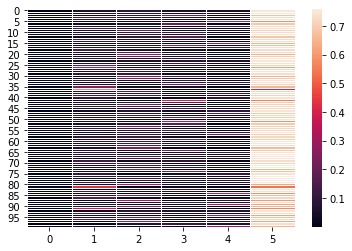

In [5]:
#uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(PMF, linewidth=0.5)
plt.show()

In [6]:
def Staging(ca, wa, PM, PMF):
    
    staging1 = wa*PMF[:, :5]
    staging1 = np.column_stack((staging1, PMF[:, 5]))
    staging2 = ca*PM[:, :5]
    staging2 = np.column_stack((staging2, list(np.logical_not(sum(staging2.T)).astype(int))))

    staging3 = []
    for i in range(len(PM)):
        staging3.append(PM[i, :]*staging2[:, 5][i])
    staging3 = np.array(staging3)

    staging4 = staging3*PMF
    
    return staging1, staging2, staging3, staging4

def Match(R1, R2, pmf):
    
    pairs_match = [[0]*6 for i in range(len(R1))]
    
    for i in range(len(R1)):
        
        if R1[i] == R2[i]:
            
            pairs_match[i][R1[i]] = 1
        
        else:
            
            pairs_match[i][-1] = 1
    
    pair_match = np.array(pairs_match)
    pair_match_prob = pair_match*pmf
    
    return pair_match, pair_match_prob, pmf
    
def Main(R1, R2, pmf, ca, wa, thresh1, thresh2):   #R1, R2 are actual sequence
    
    PM, PMP, PMF = Match(R1, R2, pmf)
    S1, S2, S3, S4 = Staging(ca, wa, PM, PMF)
    
    p1 = Algorithm1(PMF, PM, PMP, thresh1, thresh2)
    p2 = Algorithm2(PMF, PM, PMP)
    
    p3 = Algorithm3(S1, S2, S3, S4, PMP, thresh1, thresh2)
    p4 = Algorithm4(S1, S3)
    
    return p1, p2, p3, p4

In [7]:
#Simulation

In [8]:
def Sections(data):
    #Go through every section/syb-unit and save the student's username in a dictionary
    allSections = {}    
    data = df1.copy()
    DISTRICTS = data.groupby(['district_name'])
    for district_name, item in DISTRICTS:

        district = DISTRICTS.get_group(district_name)
        BLOCKS = district.groupby(['block_name'])
    
        for block_name, value in BLOCKS:
        
            block = BLOCKS.get_group(block_name)
            EDU_DISTS = block.groupby(['edu_dist_name'])
        
            for edu_name, value in EDU_DISTS:
            
                edu_dist = EDU_DISTS.get_group(edu_name)
                SCHOOLS = edu_dist.groupby(['school_name'])
            
                for school_name, value in SCHOOLS:
                
                    school = SCHOOLS.get_group(school_name)
                    SECTIONS = school.groupby(['Section'])
                
                    username = []
                    for section_name, value in SECTIONS:
                    
                        #print(district_name, block_name, edu_name, school_name, section_name)
                        section = SECTIONS.get_group(section_name)
                        #print(len(section), len(set(section['emis_username'].tolist())))
                        name = district_name+"_"+block_name+"_"+edu_name+"_"+school_name+"_"+section_name
                        allSections[name] = section['emis_username'].tolist()
                        
    return allSections

In [9]:
def proportion(students, CA, responses):
    
    pro = []
    for student in students:

        c = 0

        for ques, ans in responses[student].items():
            
            if ans == CA[ques]:
                c+=1
        
        pro.append(c)
        
    return pro

In [37]:
import random

def proportion(students, CA, responses):
    
    pro = []
    for student in students:

        c = 0

        for ques, ans in responses[student].items():
            
            if ans == CA[ques]:
                c+=1
        
        pro.append(c)
        
    return pro

def get_response(answer, CA, seed):
    
    for i in range(len(answer)):
        if answer[i] == 1:
            answer[i] = CA[i+1]
        else:
            choose = [0, 1, 2, 3, 4]
            choose.remove(CA[i+1])
            np.random.seed(seed)
            answer[i] = np.random.choice(choose)
            seed+=1
            
    answer = {i+1 : answer[i] for i in range(len(answer))}
    return answer, seed

def studentResponsesAndDistributions(response, correctAnswers):
    
    distribution = {i: {0:0, 1:0, 2:0, 3:0, 4:0} for i in correctAnswers}
                
    for student, ans in response.items():
        
        for q, a in ans.items():
            
            distribution[q][a]+=1
    
    return distribution


def Simulation(allsections, sections_beta, CA):
    
    section_sim = {}
    studentResponseswithID = {}
    seed=0    
    for i in allsections:           #Loops over section names
        
        np.random.seed(seed)
        alpha, beta = list(sections_beta.values())[np.random.choice(len(sections_beta[i]))]
        seed+=1
        #print(alpha, beta)
        if alpha < 0 or beta < 0:
            
            alpha, beta = np.random.random(), np.random.random()
            
        np.random.seed(seed)
        students = np.random.beta(alpha, beta, size=len(i))           #Student (beta distribution sample)
        seed+=1
        section_sim[i] = students                                       #Key: section_name, value: students (sample list)
        
        for student in students:
            
            proportion = student
            np.random.seed(seed)
            student_response = [np.random.random() for j in range(50)]
            seed+=1
            ans = [1 if k<=proportion else 0 for k in student_response]
            ans, seed = get_response(ans, CA, seed)
            studentResponseswithID[student] = ans
            
    return section_sim, studentResponseswithID

In [11]:
allSections = Sections(df1)  
allStudents = studentResponses(df1, CA)   #Response of all students in file using emis_username as key identifier   

In [13]:
beta_class = {}   #Beta Dist Parameteres
section_proportion = {} #Proportion of correct Answers in each section
sections_beta = {}      #Saves parameters for class

for section, students in allSections.items():
    
    value = proportion(students, CA, responses)
    section_proportion[section] = value
    #print(len(students), len(value))
    sections_beta[section] = list(beta.fit(value))[0:2]

C:\Users\venka\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:400: RuntimeWarning: invalid value encountered in double_scalars
  return m3 / np.power(m2, 1.5)
C:\Users\venka\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:411: RuntimeWarning: invalid value encountered in double_scalars
  return m4 / m2**2 - 3
C:\Users\venka\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\venka\anaconda3\lib\site-packages\scipy\optimize\optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


In [38]:
sCA = {i: list(CA.values())[:51][i] for i in range(1, 51)}
section_sim, studentResponseswithID = Simulation(allSections, sections_beta, sCA)

In [42]:
#Main(R1, R2, pmf, ca, wa, thresh1, thresh2):
def probabilityDistributions(correctAnswers, allResponsesWithStudentId, distribution):
    
    probabilityDistribution = {i: {0:0, 1:0, 2:0, 3:0, 4:0} for i in correctAnswers}
    pmf = {i: {0:0, 1:0, 2:0, 3:0, 4:0, 'mismatch':0} for i in correctAnswers}
    cdf = {i: {0:0, 1:0, 2:0, 3:0, 4:0, 'mismatch':0} for i in correctAnswers}
    
    for question, response in distribution.items():
        s = 0
        for i in response:
            probabilityDistribution[question][i] = response[i]/sum(response.values())
            s = (response[i]/sum(response.values()))**2
            pmf[question][i] = s
            cdf[question][i] += s
        pmf[question]['mismatch'] = 1 - sum(pmf[question].values())
        cdf[question]['mismatch'] = sum(pmf[question].values())
        
    return probabilityDistribution, pmf, cdf

distribution = studentResponsesAndDistributions(studentResponseswithID, sCA)
PD, PMF, CDF = probabilityDistributions(sCA, studentResponseswithID, distribution)

In [81]:
def find_pairs(n, pc, seed):

    x = int(pc*n)+1
    #print("class Length", n, "Copiers length", x)
    np.random.seed(seed)
    copied_from = list(np.random.randint(0, len(students), x))
    seed+=1
    
    return {i: i+1 for i in copied_from}, seed

def copy_response(s1, s2, pc):
    
    questions_copied = list(np.random.randint(1, 51, int(50*pc)))
    
    for q, a in s1.items():
        if q in questions_copied:
            s2[q] = a
        else:
            continue
    return s2

def correct_and_wrong_answer_binary_matrix(CA, PMF):
    
    ca = []
    for i in pmf:
        ans = list(pmf[0]).index(max(pmf[0][1:5]))
        ca.append(ans)
        
    ca = [[0]*5 for i in range(len(CA))]
    for i in range(len(CA)):
        ca[i][list(CA.values())[i]] = 1
    
    #print(PMF)
    ca_probability = np.array(ca)*PMF[:, :5]
    ca_probability = np.column_stack((ca_probability, PMF[:, 5]))

    wa = []
    for i in ca:
        wa.append(list(np.logical_not(i).astype(int)))
    wa = np.array(wa)
    
    return np.array(ca), wa

pmf = np.array([list(answer.values()) for ques, answer in PMF.items()])
ca, wa = correct_and_wrong_answer_binary_matrix(sCA, pmf)

In [91]:
def Run(sections_needed, section_sim, pmf, ca, wa, p_val, thresh1, thresh2, cp):
    
    for section in sections_needed:
        
        print("section", section)
        copied_pairs = cp[section]
        section_binary_vectors = {}

        Algo1 = []
        Algo2 = []
        Algo3 = []
        Algo4 = []

        for i in range(len(section_sim[section])-1):
            for j in range(i+1, len(section_sim[section])):

                if str(i)+"_"+str(j) not in section_binary_vectors:
                    section_binary_vectors[str(i)+"_"+str(j)] = 0

                student1 = section_sim[section][i]
                student2 = section_sim[section][j]

                response1 = studentResponseswithID[student1]
                response2 = studentResponseswithID[student2]

                if i in copied_pairs.keys():
                    if copied_pairs[i] == j:
                        #print("yes")
                        section_binary_vectors[str(i)+"_"+str(j)] = 1
                        #print("copiers", i, j)
                        response2 = copy_response(response1, response2, percentage_copied)
                        #print(list(response1.values()), list(response2.values()))

                response1 = list(response1.values())
                response2 = list(response2.values())
                
                r1, r2, r3, r4 = Main(response1, response2, pmf, ca, wa, thresh1, thresh2)
                #print(PM[:, :5])
                
                Algo1.append(1 if r1<p_val else 0) # and PM[:, :5].sum()/len(PM) >= pc
                Algo2.append(1 if r2<p_val else 0)
                Algo3.append(1 if r3<p_val else 0)
                Algo4.append(1 if r4<p_val else 0)

        actual = list(section_binary_vectors.values())
        print("Actual Copier Pairs", sum(actual))
        print(confusion_matrix(actual, Algo1))
        print(confusion_matrix(actual, Algo2))
        print(confusion_matrix(actual, Algo3))
        print(confusion_matrix(actual, Algo4))

In [96]:
sections_needed = list(section_sim.keys())[:1]

percentage_copiers = 0.20
percentage_copied = 0.8
#p_val = 1e-04

thresh1 = 0.0398
thresh2 = 0.399
pvals = [1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-10, 1e-11, 1e-12]

seed=0
copied_pairs = {}
for i in sections_needed:
    
    cp, seed = find_pairs(len(section_sim[i]), percentage_copiers, seed)
    copied_pairs[i] = cp

for i in pvals:
    
    print("Pval = ", i, "________________________________________________________________")
    Run(sections_needed, section_sim, pmf, ca, wa, i, thresh1, thresh2, copied_pairs)
    print("\n")

Pval =  0.001 ________________________________________________________________
section ARIYALUR_Andimadam_Sendurai_ADW HSS POOVANIPATTU_A
Actual Copier Pairs 9
[[1133   83]
 [   0    9]]
[[1133   83]
 [   0    9]]
[[1180   36]
 [   0    9]]
[[1170   46]
 [   0    9]]


Pval =  0.0001 ________________________________________________________________
section ARIYALUR_Andimadam_Sendurai_ADW HSS POOVANIPATTU_A
Actual Copier Pairs 9
[[1164   52]
 [   0    9]]
[[1152   64]
 [   0    9]]
[[1184   32]
 [   0    9]]
[[1182   34]
 [   0    9]]


Pval =  1e-05 ________________________________________________________________
section ARIYALUR_Andimadam_Sendurai_ADW HSS POOVANIPATTU_A
Actual Copier Pairs 9
[[1164   52]
 [   0    9]]
[[1164   52]
 [   0    9]]
[[1190   26]
 [   0    9]]
[[1184   32]
 [   0    9]]


Pval =  1e-06 ________________________________________________________________
section ARIYALUR_Andimadam_Sendurai_ADW HSS POOVANIPATTU_A
Actual Copier Pairs 9
[[1181   35]
 [   0    9]]
[[

In [88]:
copied_pairs

{'ARIYALUR_Andimadam_Sendurai_ADW HSS POOVANIPATTU_A': {12: 13,
  15: 16,
  21: 22,
  0: 1,
  3: 4,
  7: 8,
  9: 10,
  19: 20,
  18: 19}}

In [ ]:
def Run(sections_needed, section_sim, percentage_copiers, pmf, ca, wa, p_val, thresh1, thresh2, pc):
    
    for section in sections_needed:
        
        print("section", section)
        copied_pairs = find_pairs(len(section_sim[section]), percentage_copiers)
        print(copied_pairs)

        section_binary_vectors = {}

        Algo1 = []
        Algo2 = []
        Algo3 = []
        Algo4 = []

        for i in range(len(section_sim[section])-1):
            for j in range(i+1, len(section_sim[section])):

                if str(i)+"_"+str(j) not in section_binary_vectors:
                    section_binary_vectors[str(i)+"_"+str(j)] = 0

                student1 = section_sim[section][i]
                student2 = section_sim[section][j]

                response1 = studentResponseswithID[student1]
                response2 = studentResponseswithID[student2]

                if i in copied_pairs.keys():
                    if copied_pairs[i] == j:
                        #print("yes")
                        section_binary_vectors[str(i)+"_"+str(j)] = 1
                        #print("copiers", i, j)
                        response2 = copy_response(response1, response2, percentage_copied)
                        #print(list(response1.values()), list(response2.values()))
                        
                        response1 = list(response1.values())
                        response2 = list(response2.values())
                        r1, c1, r2, c2, r3, r4, PM = Main2(response1, response2, pmf, ca, wa, thresh1, thresh2)
                        
                        print(c1)
                        print(c2)
                        print("\n")

                response1 = list(response1.values())
                response2 = list(response2.values())
                
                r1, c1, r2, c2, r3, r4, PM = Main(response1, response2, pmf, ca, wa, thresh1, thresh2)
                #print(PM[:, :5])
                
                Algo1.append(1 if r1<p_val else 0) # and PM[:, :5].sum()/len(PM) >= pc
                Algo2.append(1 if r2<p_val else 0)
                Algo3.append(1 if r3<p_val else 0)
                Algo4.append(1 if r4<p_val else 0)

        actual = list(section_binary_vectors.values())
        print("Actual Copier Pairs", sum(actual))
        print(confusion_matrix(actual, Algo1))
        print(confusion_matrix(actual, Algo2))
        print(confusion_matrix(actual, Algo3))
        print(confusion_matrix(actual, Algo4))